#  1. Pull Data



Grabbing WebIDs ...
WebID collection complete!
15:26:09: Sending API request... Chunk 1 of 1
15:26:09: Response recieved for 1 tags! (0.83)
Grabbing WebIDs ...
WebID collection complete!
15:26:10: Sending API request... Chunk 1 of 1
15:26:11: Response recieved for 1 tags! (1.02)


Text(0, 0.5, 'Electricity')

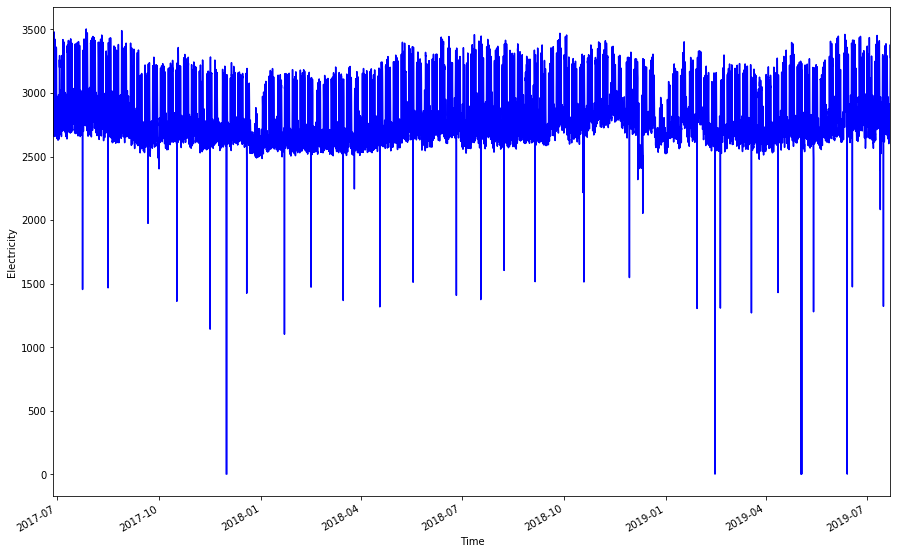

In [3]:

import sys
"""Put the path to the eco-tools folder in the following line... should look something like this one below"""
sys.path.append(r"C:\\Users\\ejgoldbe\\Desktop\\eco-tools/") #path to PI CLient
#if not working: pip install requests-kerberos Desktop
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.core.display import display, HTML
from ecotools.pi_client import pi_client
import warnings
warnings.filterwarnings('ignore')
from datetime import datetime
from dateutil.relativedelta import relativedelta
from matplotlib.lines import Line2D


pc = pi_client(root='readonly')
points = pc.search_by_point("GBSF_Electricity_Demand_kBtu")
second_points = pc.search_by_point('aitit4045*')
start = "06-28-2017"
end = "*"
interval = '1h' #can be 1d 2d for days or 1s for seconds or 1m for minutes
calculation = 'summary'
df = pc.get_stream_by_point(points, start = start, 
                            end = end, calculation=calculation,
                            interval=interval)
df2 = pc.get_stream_by_point(second_points, start = start, end = end, calculation=calculation, interval=interval)
series = pd.Series(df.iloc[:, 0], index = df.index)
plt.figure(figsize = (15, 10))
series.replace(np.nan, 0, inplace=True)
series.plot(kind = 'line', color = 'blue')
plt.xlabel("Time")
plt.ylabel("Electricity")

# Time Series Decomposition + Standard Deviation



Text(0.5, 1.0, 'Data Without Outliers')

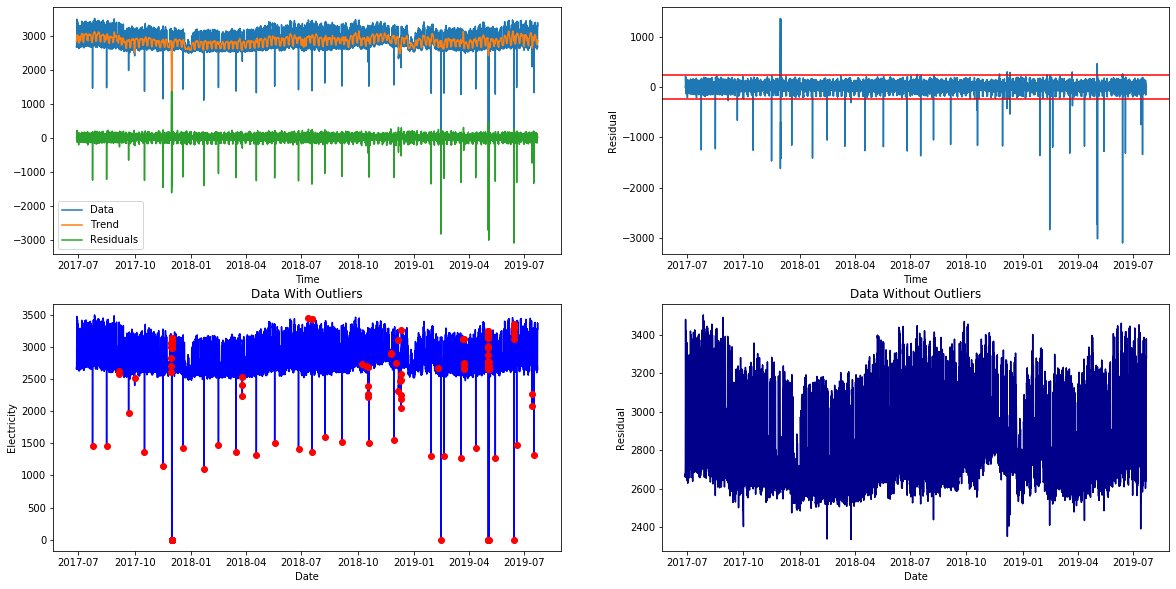

In [5]:
#first, extract trend + seasonality + noise
from statsmodels.tsa.seasonal import seasonal_decompose
electricity = pd.DataFrame(series)
electricity = electricity.asfreq("H", method="bfill")
result = seasonal_decompose(electricity)
trend = result.trend
trend = result.trend.fillna(result.trend.mean())
seasonality = result.seasonal
resid = result.resid
resid = resid.fillna(resid.mean())
plt.figure(figsize = (20, 10))
plt.subplot(2, 2, 1)
plt.plot(electricity.index, electricity.values, label = "Data")
plt.plot(trend.index, trend.values, label = "Trend")
plt.plot(resid.index, resid.values, label = "Residuals")
plt.xlabel("Time")
plt.legend(loc = "best")
#standard deviation method
upper_bound = resid.mean() + 2*np.std(resid)
lower_bound = resid.mean() - 2*np.std(resid)
#plot residuals with upper bound, lower bound marked as line
plt.subplot(2, 2, 2)
plt.plot(resid.index, resid.values)
plt.axhline(y = int(upper_bound), color = "red")
plt.axhline(y = int(lower_bound), color = "red")
plt.xlabel("Time")
plt.ylabel("Residual")

#get outliers
resids = np.ravel(resid.values).tolist()
#the residual indexes that are flagged, therefore outliers
indexes = [resids.index(r) for r in resids if r > int(upper_bound) or r < int(lower_bound)]
plt.subplot(2, 2, 3)
plt.plot(electricity.index, electricity.values, color = "blue")
for index in indexes:
    #use the residual outlier index that corresponds with the electricity outlier
    elec_outlier = np.ravel(electricity.values).tolist()[index]
    date_index = electricity.index[index]
    plt.plot(date_index, elec_outlier, color = "red", marker = "o")
plt.xlabel("Date")
plt.ylabel("Electricity")
plt.title("Data With Outliers")
    
plt.subplot(2, 2, 4)
all_data = np.ravel(electricity.values).tolist()
#extract all indexes that do not correspond with outliers
non_outliers_index = [i for i in range(electricity.shape[0]) if i not in indexes]
non_outliers = [all_data[j] for j in non_outliers_index]
non_outliers_date = [electricity.index[k] for k in non_outliers_index]
plt.plot(non_outliers_date, non_outliers, color = "darkblue")
plt.xlabel("Date")
plt.ylabel("Residual")
plt.title("Data Without Outliers")



 

# Time Series Decomposition + KMeansClustering

Cluster Totals 
 3    3035
2    3035
1    3019
0    3018
5    3002
4    3002
Name: label, dtype: int64
   x        y  label  center_x  center_y    distances  mean_cluster_distances  \
0  0  0.00534      2    1519.5  0.214311  1519.500014              768.809621   
1  1  0.00534      2    1519.5  0.214311  1518.500014              768.809621   
2  2  0.00534      2    1519.5  0.214311  1517.500014              768.809621   
3  3  0.00534      2    1519.5  0.214311  1516.500014              768.809621   
4  4  0.00534      2    1519.5  0.214311  1515.500014              768.809621   

   evaluation_value  
0          1.976432  
1          1.975131  
2          1.973831  
3          1.972530  
4          1.971229  
1.90080391929953


Text(0, 0.5, 'Electricity')

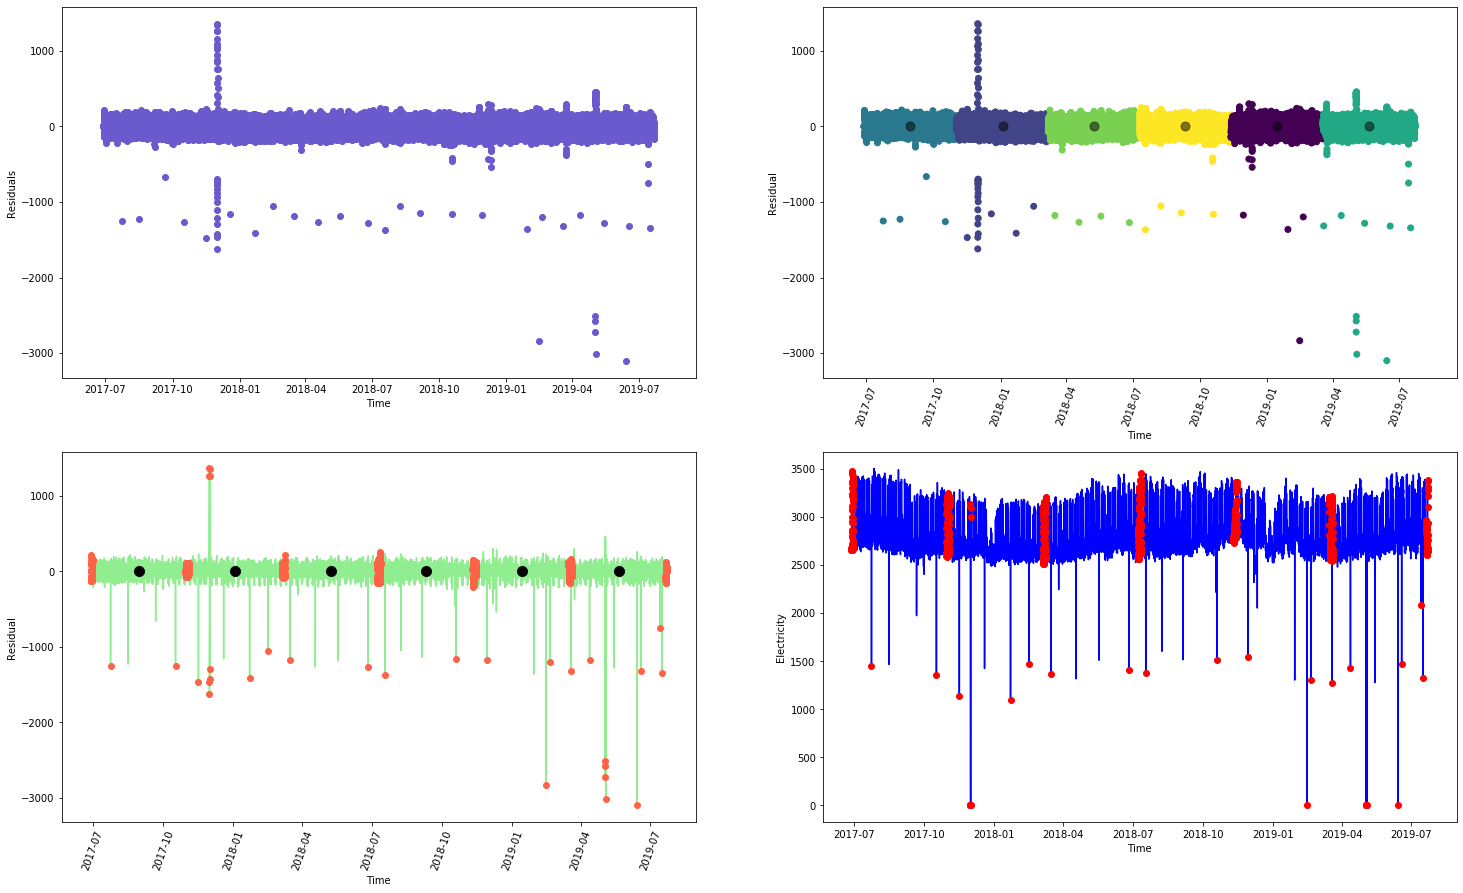

In [8]:
#this method is not as good due to it extracting outliers from points that are far from the cluster centers
#but would not be spikes in the data


from scipy.spatial import distance


y_shaped = np.array(resid)
#using KMeans
from sklearn.cluster import KMeans
x= range(resid.shape[0])
data = np.column_stack([x, y_shaped])
knn = KMeans(n_clusters = 6)
#fit kMeans to the data
knn.fit(data)
knn.cluster_centers_
plt.figure(figsize = (25, 15))
#plot original residuals
plt.subplot(2, 2, 1)
plt.scatter(resid.index, resid.values, color = 'slateblue')
plt.xlabel("Time")
plt.ylabel("Residuals")
plt.subplot(2, 2, 2)
indexes = [int(round(x, 0)) for x in knn.cluster_centers_[:, 0]]
date_indexes = [resid.index[i] for i in indexes]
plt.scatter(resid.index, resid.values, c = knn.labels_)
#plot cluster centers
plt.scatter(date_indexes, knn.cluster_centers_[:, 1], s = 80, alpha = 0.5, marker = "o", color = "black")
plt.xticks(rotation=70)
plt.xlabel("Time")
plt.ylabel("Residual")

#extract residuals
y = resid.iloc[:, 0].tolist()
kmeans_df = pd.DataFrame(dict(x = x, y = y, label = knn.labels_))
print("Cluster Totals \n", kmeans_df['label'].value_counts())
#extract cluster center for each individual point
cluster_centers = knn.cluster_centers_.tolist()
all_labels = [int(k) for k in kmeans_df['label'].tolist()]
each_cluster_center_x = [cluster_centers[j][0] for j in all_labels]
each_cluster_center_y = [cluster_centers[l][1] for l in all_labels]
kmeans_df['center_x'] = each_cluster_center_x
kmeans_df['center_y'] = each_cluster_center_y
#extract the distance from each individual point to the cluster center
m = range(kmeans_df.shape[0])
distances = [distance.euclidean((kmeans_df.iloc[i, 0], kmeans_df.iloc[i, 1]), (kmeans_df.iloc[i, 3],
                                                        kmeans_df.iloc[i, 4])) for i in m]
#add to the dataframe
kmeans_df['distances'] = distances
#compare the distance of each point to its cluster center, to the mean cluster distances
#first, extract the mean cluster distances
mean_cluster_distances = kmeans_df.groupby('label')['distances'].mean().tolist()
#from there, get the evaluation value - each point's distance to the cluster center, divided by the average distance of all 
#points to the center for that cluster
all_mean_cluster_distances = [mean_cluster_distances[i] for i in kmeans_df['label'].tolist()]
kmeans_df['mean_cluster_distances'] = all_mean_cluster_distances
kmeans_df['evaluation_value'] = kmeans_df['distances']/kmeans_df['mean_cluster_distances']
#determine the threshold for an outlier
threshold_evaluation_value = kmeans_df['evaluation_value'].mean() + 1.6*np.std(kmeans_df['evaluation_value'])
print(kmeans_df.head(5))
print(threshold_evaluation_value)
evaluation_outliers_indexes = [kmeans_df['evaluation_value'].tolist().index(o) for o in kmeans_df['evaluation_value'].tolist()
                       if o > threshold_evaluation_value]
#plot residuals
plt.subplot(2, 2, 3)
plt.plot(resid.index, resid.values, color = 'lightgreen', zorder=1)
plt.scatter(date_indexes, knn.cluster_centers_[:, 1], s = 100, marker = "o", color = "black", zorder=2)
for index in evaluation_outliers_indexes:
    residual_outlier = resid.values.tolist()[index]
    date_index = resid.index.tolist()[index]
    plt.plot(date_index, residual_outlier, marker = 'o', color = 'tomato')
plt.xlabel("Time")
plt.ylabel("Residual")
plt.xticks(rotation = 70)

#then plot data with outliers
plt.subplot(2, 2, 4)
#retrieve electricity based on outlier indexes
plt.plot(electricity.index, electricity.values, color = 'blue')
for index in evaluation_outliers_indexes:
    elec_outlier = electricity.values.tolist()[index]
    date_index = electricity.index[index]
    plt.plot(date_index, elec_outlier, marker = 'o', color = 'red')
plt.xlabel("Time")
plt.ylabel("Electricity")


# Time Series Decomposition + Agglomerative Clustering

Text(0.5, 1.0, 'Data Without Outliers')

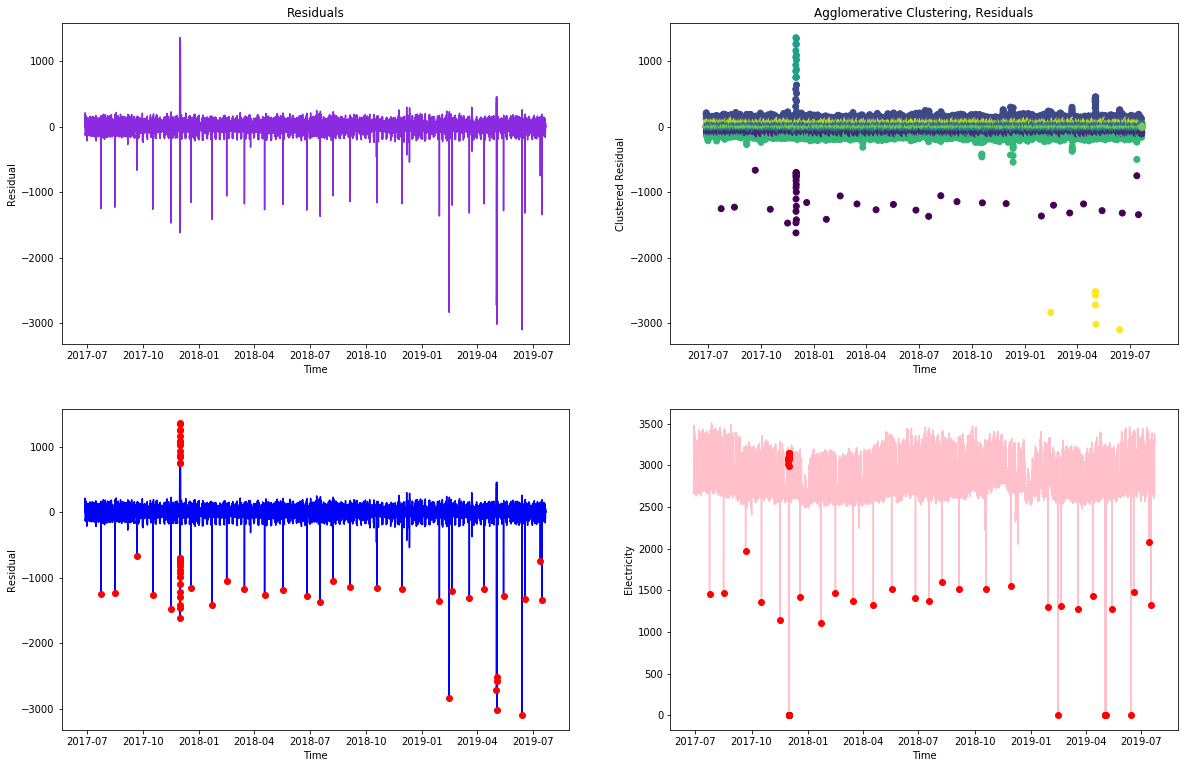

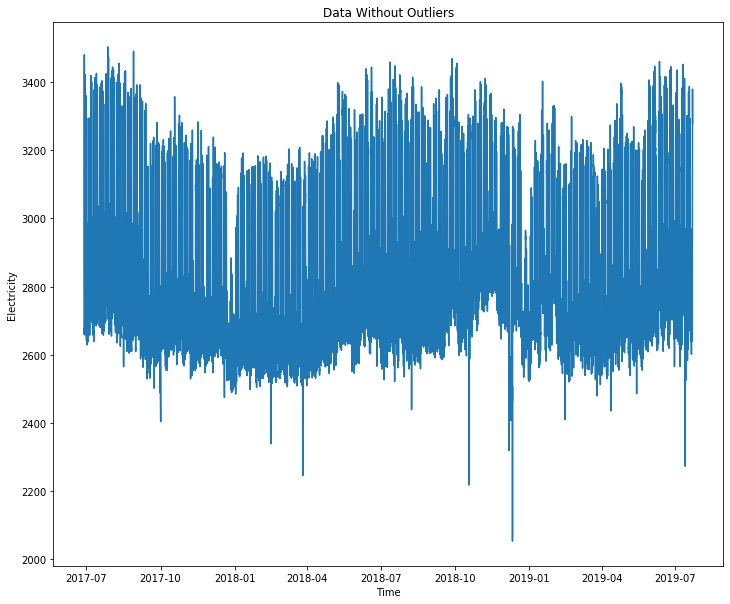

In [9]:
from sklearn.cluster import AgglomerativeClustering


#extract residuals and plot again
resid.head(5)
plt.figure(figsize = (20, 13))
plt.subplot(2, 2, 1)
plt.plot(resid.index, resid.values, color = 'blueviolet')
plt.xlabel("Time")
plt.ylabel("Residual")
plt.title("Residuals")
#second plot: fit aggclustering to residuals, then scatter: plt.scatter(resid.index, resid.values, c = labels)
#fit clustering algo
agg_cluster = AgglomerativeClustering(n_clusters = 10)
#fit to data
data = resid.values.reshape(-1, 1)
agg_cluster.fit(data)
labels = agg_cluster.labels_
plt.subplot(2, 2, 2)
plt.scatter(resid.index, resid.values, c = labels)
plt.xlabel("Time")
plt.ylabel("Clustered Residual")
plt.title("Agglomerative Clustering, Residuals")
#third plot: extract residual outliers and plot
plt.subplot(2, 2, 3)
agg_df = pd.DataFrame({'resid': np.ravel(resid.values), 'label': labels.tolist()})
#extract the highest and lowest clusters and flag all residuals within those as outliers
sorted_agg = agg_df.groupby(['label'])['resid'].mean()
sorted_agg = sorted_agg.sort_values(ascending=False)
highest_cluster = sorted_agg.index[0]
lowest_cluster = sorted_agg.index[9]
second_lowest_cluster = sorted_agg.index[8]
agg_df = agg_df[(agg_df['label'] == highest_cluster) | (agg_df['label'] == lowest_cluster) | 
                (agg_df['label'] == second_lowest_cluster)]
residual_outliers = agg_df['resid'].tolist()
plt.plot(resid.index, resid.values, color = 'blue')
for outlier in residual_outliers:
    index = np.ravel(resid.values).tolist().index(outlier)
    date_index = resid.index[index]
    plt.plot(date_index, outlier, color = 'red', marker = 'o')
plt.xlabel("Time")
plt.ylabel("Residual")


#fourth plot: original outliers
plt.subplot(2, 2, 4)
#extract outlier indexes from residuals
outlier_indexes = agg_df['resid'].index
plt.plot(electricity.index, electricity.values, color = 'pink')
for index in outlier_indexes:
    elec_outlier = electricity.values.tolist()[index]
    date_index = electricity.index[index]
    plt.plot(date_index, elec_outlier, color = 'red', marker = 'o')
plt.xlabel("Time")
plt.ylabel("Electricity")

#fifth plot: data with outliers removed
fig, ax  = plt.subplots(1, 1, figsize = (12, 10))
all_indexes = range(electricity.shape[0])
non_outlier_indexes = [i for i in all_indexes if i not in outlier_indexes]
non_outlier_data = [electricity.values.tolist()[i] for i in non_outlier_indexes]
non_outlier_dates = [electricity.index[i] for i in non_outlier_indexes]
ax.plot(non_outlier_dates, non_outlier_data)
ax.set_xlabel("Time")
ax.set_ylabel("Electricity")
ax.set_title("Data Without Outliers")



